In [1]:
# Leer archivos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score




In [2]:
# Leer archivos
#df_test = pd.read_csv("/content/drive/MyDrive/GSCred/cs-test.csv")
df = pd.read_csv("/content/drive/MyDrive/GSCred/cs-training.csv")
df.reset_index(drop=True,inplace=True)
df.insert(0,'ID',df.index+1)
df.set_index('ID',inplace=True)
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
ID,,,,,,,,,,,,
1,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  Numbe

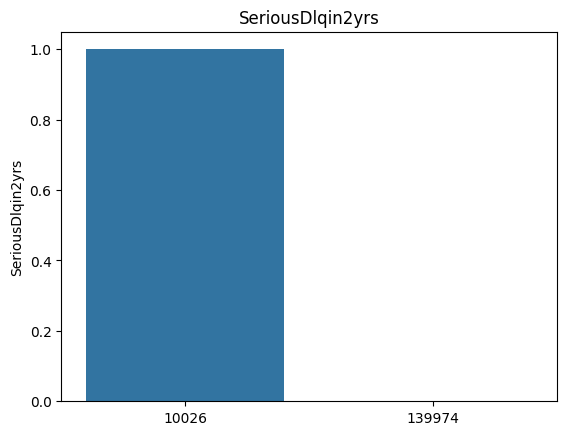

In [ ]:
sns.barplot(y=df['SeriousDlqin2yrs'].value_counts().index,x=df['SeriousDlqin2yrs'].value_counts().values).set_title('SeriousDlqin2yrs')
plt.show()

In [4]:
# Codificar las variables categóricas
df["NumberOfTime30-59DaysPastDueNotWorse"] = df["NumberOfTime30-59DaysPastDueNotWorse"].apply(lambda x: 1 if x >= 1 else 0)
df["NumberOfTime60-89DaysPastDueNotWorse"] = df["NumberOfTime60-89DaysPastDueNotWorse"].apply(lambda x: 1 if x >= 1 else 0)
df["NumberOfTimes90DaysLate"] = df["NumberOfTimes90DaysLate"].apply(lambda x: 1 if x >= 1 else 0)
df["NumberOfOpenCreditLinesAndLoans"] = df["NumberOfOpenCreditLinesAndLoans"].apply(lambda x: 1 if x >= 1 else 0)
df["NumberRealEstateLoansOrLines"] = df["NumberRealEstateLoansOrLines"].apply(lambda x: 1 if x >= 1 else 0)
df["NumberOfDependents"] = df["NumberOfDependents"].apply(lambda x: 1 if x >= 1 else 0)


In [5]:

X= df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

In [6]:
# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

target=['SeriousDlqin2yrs']
train,test=train_test_split(df,test_size=0.3,random_state=24,stratify=df[target])
train.shape,test.shape


((105000, 12), (45000, 12))

In [7]:
# Crear el modelo xgboost
model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    reg_alpha=1,
    reg_lambda=1,
    scale_pos_weight=1,
    objective='binary:logistic',
    random_state=42
)

In [8]:
#Entrenar el modelo
#y_train = y_train.fillna(0) #Para quitar los NaN y remplazarlos por 0 y así sea un valor numerico
target=['SeriousDlqin2yrs']

varc=['RevolvingUtilizationOfUnsecuredLines','DebtRatio',
      'MonthlyIncome']

vard=['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate',
      'NumberRealEstateLoansOrLines','NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents',
      'age','NumberOfOpenCreditLinesAndLoans']
def outliers(df:pd.DataFrame,lower:float=.005,upper:float=.995)->tuple:
    X=df.copy()
    l,u=X.quantile([lower]).values,X.quantile([upper]).values
    X['extremo']=np.where((X>u).sum(axis=1)+(X<l).sum(axis=1)==0,0,1)
    no_outliers=X[X['extremo']==0].drop('extremo',axis=1)
    return no_outliers
#model.fit(X_train, y_train)

In [9]:
train_=outliers(train)

In [10]:
from sklearn.impute import SimpleImputer
imp_c=SimpleImputer(strategy='mean')
imp_d=SimpleImputer(strategy='most_frequent')
imp_c.fit(train_[varc]),imp_d.fit(train_[vard])


(SimpleImputer(), SimpleImputer(strategy='most_frequent'))

In [11]:
train_[varc]=imp_c.transform(train_[varc])
train_[vard]=imp_d.transform(train_[vard])
train_.describe(percentiles=[.01,.05,.10,.25,.50,.75,.90,.95,.99]).round(2)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,101602.00,101602.00,101602.00,101602.00,101602.00,101602.00,101602.00,101602.00,101602.00,101602.00,101602.00,101602.00
mean,74919.55,0.07,0.32,52.26,0.16,295.76,6313.47,0.99,0.05,0.63,0.05,0.40
std,42830.38,0.25,0.35,14.48,0.37,860.05,3843.03,0.11,0.23,0.48,0.22,0.49
min,772.00,0.00,0.00,23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1%,2229.01,0.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5%,8247.10,0.00,0.00,29.00,0.00,0.00,1550.00,1.00,0.00,0.00,0.00,0.00
10%,15649.10,0.00,0.00,33.00,0.00,0.04,2350.00,1.00,0.00,0.00,0.00,0.00
25%,37793.25,0.00,0.03,41.00,0.00,0.18,3901.00,1.00,0.00,0.00,0.00,0.00
50%,74820.50,0.00,0.15,52.00,0.00,0.37,6313.47,1.00,0.00,1.00,0.00,0.00
75%,112052.75,0.00,0.55,63.00,0.00,0.83,7400.00,1.00,0.00,1.00,0.00,1.00


In [12]:
from sklearn.model_selection import RandomizedSearchCV,cross_val_score

grid={'n_estimators':range(20,501,20),'max_depth':range(1,6),'learning_rate':[.0001,.001,.01,.1,1,10],'n_jobs':[-1],
      'subsample':[.4,.5,.6,.7,.8,.9,1],'random_state':[0]}
xgb_grid=RandomizedSearchCV(model,grid,cv=5,scoring='roc_auc',n_iter=20,n_jobs=-1,random_state=24)
xgb_grid.fit(train_[varc+vard],train_[target])

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1, 10],
                                        'max_depth': range(1, 6),
                                        'n_estimators': range(20, 501, 20),
                                        'n_jobs': [-1], 'random_state': [0],
                                        'subsample': [0.4, 0.5, 0.6, 0.7, 0.8,
                                                      0.9, 1]},
                   random_state=24, scoring='roc_auc')

In [13]:
mod=xgb_grid.best_estimator_
mod

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, random_state=0, ...)

In [14]:
auc = roc_auc_score(train_[target],mod.predict_proba(train_[varc+vard])[:,1])
print(f'AUC: {auc}')


AUC: 0.862555170290991


continuando con el test

In [15]:
test_imp = test.copy()
test_imp[varc]=imp_c.transform(test[varc])
test_imp[vard]=imp_d.transform(test[vard])
test_imp.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
ID,,,,,,,,,,,,
103371,103371,0,0.016135,61,0,0.020947,4200.0,1,0,0,0,1
48446,48446,1,0.718657,55,0,0.705937,12833.0,1,0,1,0,0
74172,74172,0,0.168523,38,0,0.330087,4825.0,1,0,1,0,1
112404,112404,0,0.233777,48,1,0.433428,6000.0,1,0,1,0,1
127704,127704,0,0.999911,49,1,0.146971,5000.0,1,1,0,1,0


In [16]:
auc_ = roc_auc_score(test_imp[target],mod.predict_proba(test_imp[varc+vard])[:,1])
print(f'AUC: {auc}')

AUC: 0.862555170290991


In [17]:
pred = pd.read_csv("/content/drive/MyDrive/GSCred/cs-test.csv")
pred['Id']=pred['Unnamed: 0']
pred[varc]=imp_c.transform(pred[varc])
pred[vard]=imp_d.transform(pred[vard])
pred['Probability']=mod.predict_proba(pred[varc+vard])[:,1]
pred

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Id,Probability
0,1,NaN,0.885519,43.0,0.0,0.177513,5700.00000,4.0,0.0,0.0,0.0,0.0,1,0.071114
1,2,NaN,0.463295,57.0,0.0,0.527237,9141.00000,15.0,0.0,4.0,0.0,2.0,2,0.035548
2,3,NaN,0.043275,59.0,0.0,0.687648,5083.00000,12.0,0.0,1.0,0.0,2.0,3,0.021193
3,4,NaN,0.280308,38.0,1.0,0.925961,3200.00000,7.0,0.0,2.0,0.0,0.0,4,0.111849
4,5,NaN,1.000000,27.0,0.0,0.019917,3865.00000,4.0,0.0,0.0,0.0,1.0,5,0.115254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101498,101499,NaN,0.282653,24.0,0.0,0.068522,1400.00000,5.0,0.0,0.0,0.0,0.0,101499,0.037877
101499,101500,NaN,0.922156,36.0,3.0,0.934217,7615.00000,8.0,0.0,2.0,0.0,4.0,101500,0.327732
101500,101501,NaN,0.081596,70.0,0.0,836.000000,6313.47223,3.0,0.0,0.0,0.0,0.0,101501,0.007062
101501,101502,NaN,0.335457,56.0,0.0,3568.000000,6313.47223,8.0,0.0,2.0,1.0,3.0,101502,0.076977


In [ ]:
pred[['Id','Probability']].to_csv('xgboost.csv', index=False)